# ESRGAN
In this tutorial, you will learn:
- An enhanced super-resolution algorithm ([ESRGAN](https://arxiv.org/abs/1809.00219)) for better visual quality.
- [Deep Network Interpolation](https://arxiv.org/abs/1811.10515) (DNI), a technique for balancing PSNR-oriented outputs and perceptual restorations. 

Let's start!

# Install MMEditing

In [ ]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# Install mmcv from source
!rm -rf mmcv
!git clone https://github.com/open-mmlab/mmcv.git
%cd mmcv
!MMCV_WITH_OPS=1 pip install .
%cd ..

# Install mmediting, it may take a while to install mmcv-full
!rm -rf mmediting
!git clone https://github.com/open-mmlab/mmediting.git
%cd mmediting
!pip install -r requirements.txt
!pip install -e .

Cloning into 'mmcv'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 4159 (delta 9), reused 12 (delta 5), pack-reused 4124
Receiving objects: 100% (4159/4159), 5.88 MiB | 8.92 MiB/s, done.
Resolving deltas: 100% (2827/2827), done.
/content/mmcv
Processing /content/mmcv
     |████████████████████████████████| 194kB 9.3MB/s 
  Created wheel for mmcv-full: filename=mmcv_full-1.1.4-cp36-cp36m-linux_x86_64.whl size=15929218 sha256=a06a471f5796e1f8769fd08874775748171344e6af452c9673f66b72a6715eb8
  Stored in directory: /tmp/pip-ephem-wheel-cache-ih5fk9od/wheels/34/64/a6/92de36f9cc2a71f8e295327009ecfa148ddb9d38beef63ed71
Successfully built mmcv-full
/content
Cloning into 'mmediting'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 4676 (delta 15), reused 25 (delta 7), pack-reused 4618
Receivin

In [ ]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMEditing installation
import mmedit
print(mmedit.__version__)

1.6.0+cu101 True
0.5.0


# SRCNN Recap
We have already run SRCNN and familiarized ourselves with it.

SRCNN is a very simple CNN-based method for super-resolution. It contains only three convolution layers, each performing a function:

- The first convolution layer performs feature extraction;
- The second convolution layer with activation functions performs non-linear mapping;
- The last convolution layer converts the features back to images by reconstruction.

With increasing model capacity and improved model structures, will the model perform better?

Now let's try a much larger model.

# From SRCNN to A Larger Model
Here, we choose the RRDB-Net, which is short for Residual in Residual Dense Block Network.

Let's fist look at its network structure! Just take a glance at it. You are not required to know every detail of it

The overall structure is as follows:

![RRDB-Net](https://raw.githubusercontent.com/xinntao/public-figures/master/MMEditing-Tutorial/RRDB-Net.png)

Inside each basic block is the RRDB, which combines the merits of ResNet and DenseNet:

![RRDB](https://raw.githubusercontent.com/xinntao/public-figures/master/MMEditing-Tutorial/RRDB.png)

Now let's run a pre-trained RRDB-Net with baboon!

First, download pre-trained models and data.

In [ ]:
# Download pre-trained models
!mkdir checkpoints
!wget -c https://openmmlab.oss-accelerate.aliyuncs.com/mmediting/restorers/esrgan/esrgan_psnr_x4c64b23g32_1x16_1000k_div2k_20200420-bf5c993c.pth \
    -O checkpoints/esrgan_psnr_x4c64b23g32_1x16_1000k_div2k_20200420-bf5c993c.pth
!wget -c https://openmmlab.oss-accelerate.aliyuncs.com/mmediting/restorers/srcnn/srcnn_x4k915_1x16_1000k_div2k_20200608-4186f232.pth \
    -O checkpoints/srcnn_x4k915_1x16_1000k_div2k_20200608-4186f232.pth
!wget -c https://openmmlab.oss-accelerate.aliyuncs.com/mmediting/restorers/esrgan/esrgan_x4c64b23g32_1x16_400k_div2k_20200508-f8ccaf3b.pth \
    -O checkpoints/esrgan_x4c64b23g32_1x16_400k_div2k_20200508-f8ccaf3b.pth

--2020-10-01 06:31:15--  https://openmmlab.oss-accelerate.aliyuncs.com/mmediting/restorers/esrgan/esrgan_psnr_x4c64b23g32_1x16_1000k_div2k_20200420-bf5c993c.pth
Resolving openmmlab.oss-accelerate.aliyuncs.com (openmmlab.oss-accelerate.aliyuncs.com)... 47.254.186.225
Connecting to openmmlab.oss-accelerate.aliyuncs.com (openmmlab.oss-accelerate.aliyuncs.com)|47.254.186.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66914297 (64M) [application/octet-stream]
Saving to: ‘checkpoints/esrgan_psnr_x4c64b23g32_1x16_1000k_div2k_20200420-bf5c993c.pth’

checkpoints/esrgan_ 100%[===================>]  63.81M  8.86MB/s    in 7.6s    

2020-10-01 06:31:25 (8.43 MB/s) - ‘checkpoints/esrgan_psnr_x4c64b23g32_1x16_1000k_div2k_20200420-bf5c993c.pth’ saved [66914297/66914297]

--2020-10-01 06:31:25--  https://openmmlab.oss-accelerate.aliyuncs.com/mmediting/restorers/srcnn/srcnn_x4k915_1x16_1000k_div2k_20200608-4186f232.pth
Resolving openmmlab.oss-accelerate.aliyuncs.com (open

In [ ]:
# download data
!mkdir data
!wget https://raw.githubusercontent.com/open-mmlab/mmediting/master/tests/data/lq/baboon_x4.png
!wget https://raw.githubusercontent.com/open-mmlab/mmediting/master/tests/data/gt/baboon.png
!wget https://raw.githubusercontent.com/xinntao/public-figures/master/MMEditing-Tutorial/zebra_x4.png
!mv baboon_x4.png ./data/baboon_x4.png
!mv baboon.png ./data/baboon.png
!mv zebra_x4.png ./data/zebra_x4.png

--2020-10-01 06:32:31--  https://raw.githubusercontent.com/open-mmlab/mmediting/master/tests/data/lq/baboon_x4.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33918 (33K) [image/png]
Saving to: ‘baboon_x4.png’

baboon_x4.png       100%[===================>]  33.12K  --.-KB/s    in 0.004s  

2020-10-01 06:32:31 (8.36 MB/s) - ‘baboon_x4.png’ saved [33918/33918]

--2020-10-01 06:32:31--  https://raw.githubusercontent.com/open-mmlab/mmediting/master/tests/data/gt/baboon.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 553249 (540K) [imag



# Inference with RRDB-Net in MMEditing

In [ ]:
! mkdir results
# Inference with SRCNN
! python demo/restoration_demo.py configs/restorers/srcnn/srcnn_x4k915_g1_1000k_div2k.py checkpoints/srcnn_x4k915_1x16_1000k_div2k_20200608-4186f232.pth data/baboon_x4.png results/baboon_SRCNN.png
# Inference with RRDB-Net
! python demo/restoration_demo.py configs/restorers/esrgan/esrgan_psnr_x4c64b23g32_g1_1000k_div2k.py checkpoints/esrgan_psnr_x4c64b23g32_1x16_1000k_div2k_20200420-bf5c993c.pth data/baboon_x4.png results/baboon_RRDB-Net.png

mkdir: cannot create directory ‘results’: File exists


Let's look inside the codes!

We will write python codes with MMEditing high-level APIs to perform super-resolution.

In [ ]:
import mmcv
import torch
from mmedit.apis import init_model, restoration_inference
from mmedit.core import tensor2img

# Configurations 
config = 'configs/restorers/esrgan/esrgan_psnr_x4c64b23g32_g1_1000k_div2k.py'
checkpoint = 'checkpoints/esrgan_psnr_x4c64b23g32_1x16_1000k_div2k_20200420-bf5c993c.pth'
img_path = 'data/baboon_x4.png'
save_path = 'results/baboon_RRDB-Net.png'

# Initilize model
model = init_model(
        config, checkpoint, device=torch.device('cuda'))

# Inference
output = restoration_inference(model, img_path)

# Change the network output to images
output = tensor2img(output)

# Save images
mmcv.imwrite(output, save_path)

True

# Visualize Outputs

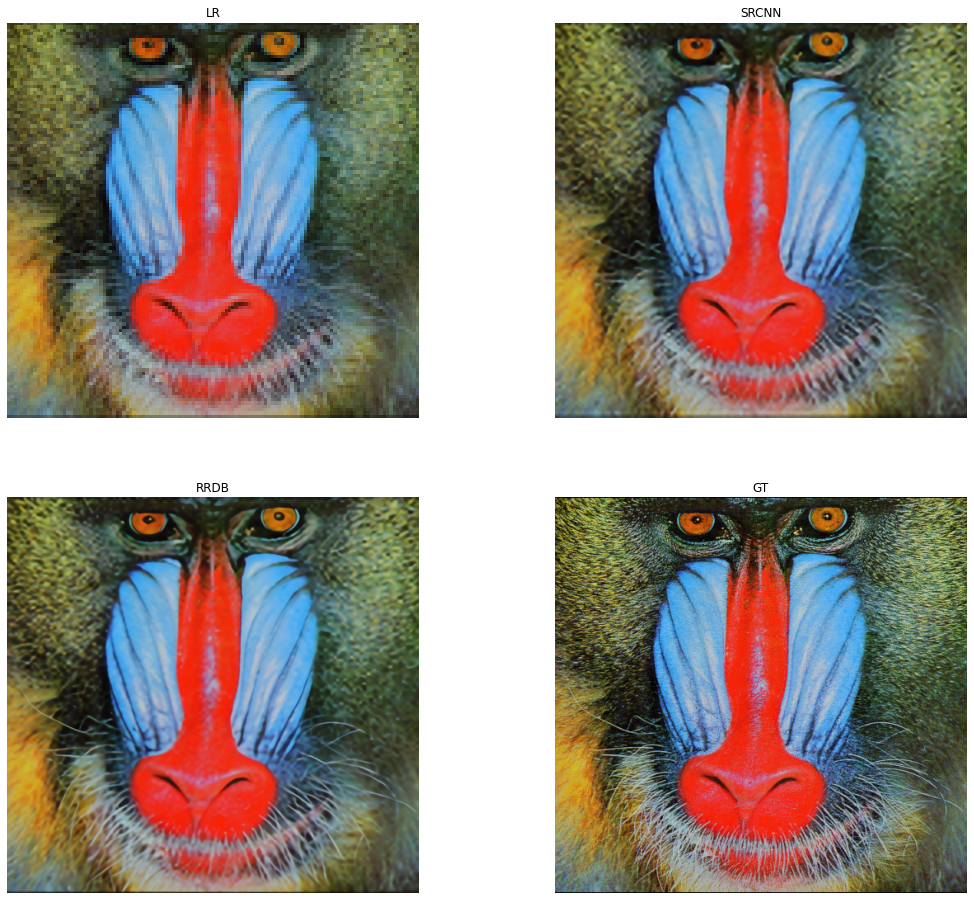

In [ ]:
%matplotlib inline 
import mmcv
import matplotlib.pyplot as plt

# Load LR and GT images
img_lr = mmcv.imread('./data/baboon_x4.png', channel_order='rgb')  # read LR image
img_gt = mmcv.imread('./data/baboon.png', channel_order='rgb')  # read GT (Ground-Truth) image

# Load SRCNN and RRDB-Net results
img_srcnn = mmcv.imread('./results/baboon_SRCNN.png', channel_order='rgb')
img_rrdb_net = mmcv.imread('./results/baboon_RRDB-Net.png', channel_order='rgb')

# Plot figures
fig = plt.figure(figsize=(18, 16))
ax1 = fig.add_subplot(2, 2, 1)  # 2 rows, 2 columns, the top left image  
ax1.title.set_text('LR')
ax1.axis('off')
ax2 = fig.add_subplot(2, 2, 2)  # 2 rows, 2 columns, the top right image  
ax2.title.set_text('SRCNN')
ax2.axis('off')
ax3 = fig.add_subplot(2, 2, 3)  # 2 rows, 2 columns, the top right image  
ax3.title.set_text('RRDB')
ax3.axis('off')
ax4 = fig.add_subplot(2, 2, 4)  # 2 rows, 2 columns, the bottom right image  
ax4.title.set_text('GT')
ax4.axis('off')
ax1.imshow(img_lr)
ax2.imshow(img_srcnn)
ax3.imshow(img_rrdb_net)
ax4.imshow(img_gt)

The top left is the input low-resolution image. The top right is the SRCNN output. The bottom left is the larger RRDB-Net result, while the bottom right is the ground truth. 

These results suggest that we can recover better results with sharper edges by using a model with a higher capacity and improved structure. 

However, even though the output of RRDB-Net has **sharper edges** than that of SRCNN, the **textures of the baboon** is still unsatisfactory compared to the ground truth, especially the whiskers. 

For human beings, we prefer outputs with higher perceptual quality more than PSNR-oriented outputs. 


# Perceptual Quality

Let's try ESRGAN for better perceptual quality.

The network structure is the same as that of RRDB-net. However, it is trained with [GAN loss](https://arxiv.org/abs/1609.04802) and [perceptual loss](https://arxiv.org/abs/1603.08155). 



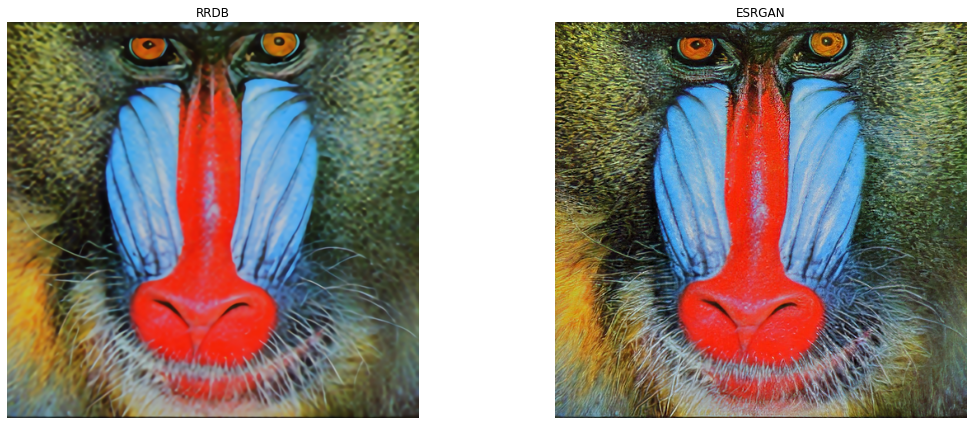

In [ ]:
# Configuations 
config = 'configs/restorers/esrgan/esrgan_x4c64b23g32_g1_400k_div2k.py'
checkpoint = 'checkpoints/esrgan_x4c64b23g32_1x16_400k_div2k_20200508-f8ccaf3b.pth'
img_path = 'data/baboon_x4.png'
save_path = 'results/baboon_ESRGAN.png'

# Initilize model
model = init_model(
        config, checkpoint, device=torch.device('cuda'))

# Inference
output = restoration_inference(model, img_path)
output = tensor2img(output)

mmcv.imwrite(output, save_path)

# Visualize 
img_esrgan = mmcv.imread('results/baboon_ESRGAN.png', channel_order='rgb')

fig = plt.figure(figsize=(18, 16))
ax1 = fig.add_subplot(2, 2, 1)
ax1.title.set_text('RRDB')
ax1.axis('off')
ax2 = fig.add_subplot(2, 2, 2)
ax2.title.set_text('ESRGAN')
ax2.axis('off')

ax1.imshow(img_rrdb_net)
ax2.imshow(img_esrgan)

Compare the picture on the left and on the right. Is the new outcome much improved? This is the magic of generative adversarial network and perceptual loss!

## Metrics

Usually we use some metrics to measure the image quality after super-resolution. Here we introduce two metrics: PSNR and NIQE. 

### PSNR (Peak Signal-to-Noise Ratio)

We usually measure the output with Peak Signal-to-Noise Ratio, often abbreviated PSNR. It is an engineering term for the ratio between the maximum possible power of a signal and the power of corrupting noise that affects the fidelity of its representation.

The formulation is as follows:
Given a m×n image I and its approximation K, MSE is defined as:

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/3a34719b4f391dba26b3e8e4460b7595d62eece4)

The PSNR (in dB) is defined as:

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/fc22801ed1232ff1231c4156b589de5c32063a8a)

Here, MAX is the maximum possible pixel value of the image. When the pixels are represented using 8 bits per sample, this is 255. 

 

We can calculate the PSNR of each image using MMEditing metric functions.

In [ ]:
from mmedit.core.evaluation import psnr, niqe
# Bicubic images
h, w, c = img_lr.shape
img_bic, _, _ = mmcv.imresize(img_lr, (w * 4, h * 4), 'bicubic')
psnr_bic = psnr(img_bic, img_gt, crop_border=4, input_order='HWC')
print('PSNR for bicubic image: ', psnr_bic)

PSNR for bicubic image:  28.97782722734658


In [ ]:
# PSNRs for SRCNN and RRDB-Net
psnr_srcnn = psnr(img_srcnn, img_gt, crop_border=4, input_order='HWC')
psnr_rrdb_net = psnr(img_rrdb_net, img_gt, crop_border=4, input_order='HWC')
psnr_esrgan = psnr(img_esrgan, img_gt, crop_border=4, input_order='HWC')
print('PSNR for SRCNN image: ', psnr_srcnn)
print('PSNR for RRDB-Net image: ', psnr_rrdb_net)
print('PSNR for ESRGAN: ', psnr_esrgan)

PSNR for SRCNN image:  29.12507085960765
PSNR for RRDB-Net image:  29.241922113651995
PSNR for ESRGAN:  28.815048207751484


We can see that RRDB-Net output has a higher PSNR than SRCNN output. Interestingly, the PSNR of ESRGAN output is lower than that of RRDB-Net and SRCNN output, even though ESRGAN has a more visual-pleasing effect.

So, PSNR is not a good metric for reflecting the perceptual quality.

Therefore, we introduce another metric that is able to reflect the perceptual quality of super-resolution - NIQE.

### NIQE (Natural Image Quality Evaluator) 
NIQE is a no-reference image quality evaluator that assesses image quality without knowledge of anticipated distortions or human opinions of them. The quality of the distorted image is expressed as a simple distance metric between the
model statistics and those of the distorted image. Such a model has great potential to be
applied in unconstrained environments.

Paper: [Making a "Completely Blind" Image Quality Analyzer](http://live.ece.utexas.edu/research/Quality/niqe_spl.pdf)

We can also call NIQE functions using MMEditing APIs.

In [ ]:
# Calculate NIQE of ESRGAN
niqe_bic = niqe(img_bic, crop_border=4, input_order='HWC')
niqe_srcnn = niqe(img_srcnn, crop_border=4, input_order='HWC')
niqe_rreb_net = niqe(img_rrdb_net, crop_border=4, input_order='HWC')
niqe_esrgan = niqe(img_esrgan, crop_border=4, input_order='HWC')
niqe_gt = niqe(img_gt, crop_border=4, input_order='HWC')

print('NIQE for bicubic image: ', niqe_bic)
print('NIQE for SRCNN image: ', niqe_srcnn)
print('NIQE for RRDB-Net image: ', niqe_rreb_net)
print('NIQE for ESRGAN image: ', niqe_esrgan)
print('NIQE for GT image: ', niqe_gt)

NIQE for bicubic image:  [[11.01545448]]
NIQE for SRCNN image:  [[7.35630779]]
NIQE for RRDB-Net image:  [[5.07940419]]
NIQE for ESRGAN image:  [[4.21316539]]
NIQE for GT image:  [[6.22157055]]


The ESRGAN result could produce lower NIQE, indicating better visual quality. 

However, this metric is also not perfect. From the above values, we can also see that the GT image has a higher NIQE value than outputs of RRDB-Net and ESRGAN, which is not reasonable.

# Try it Yourself!

You can use other images from the dataset and super-resolve them~

In [ ]:
# Inference with SRCNN
! python demo/restoration_demo.py configs/restorers/srcnn/srcnn_x4k915_g1_1000k_div2k.py checkpoints/srcnn_x4k915_1x16_1000k_div2k_20200608-4186f232.pth data/zebra_x4.png results/zebra_SRCNN.png
# Inference with RRDB-Net
! python demo/restoration_demo.py configs/restorers/esrgan/esrgan_psnr_x4c64b23g32_g1_1000k_div2k.py checkpoints/esrgan_psnr_x4c64b23g32_1x16_1000k_div2k_20200420-bf5c993c.pth data/zebra_x4.png results/zebra_RRDB-Net.png
# Inference with ESRGAN
! python demo/restoration_demo.py configs/restorers/esrgan/esrgan_x4c64b23g32_g1_400k_div2k.py checkpoints/esrgan_x4c64b23g32_1x16_400k_div2k_20200508-f8ccaf3b.pth data/zebra_x4.png results/zebra_ESRGAN.png

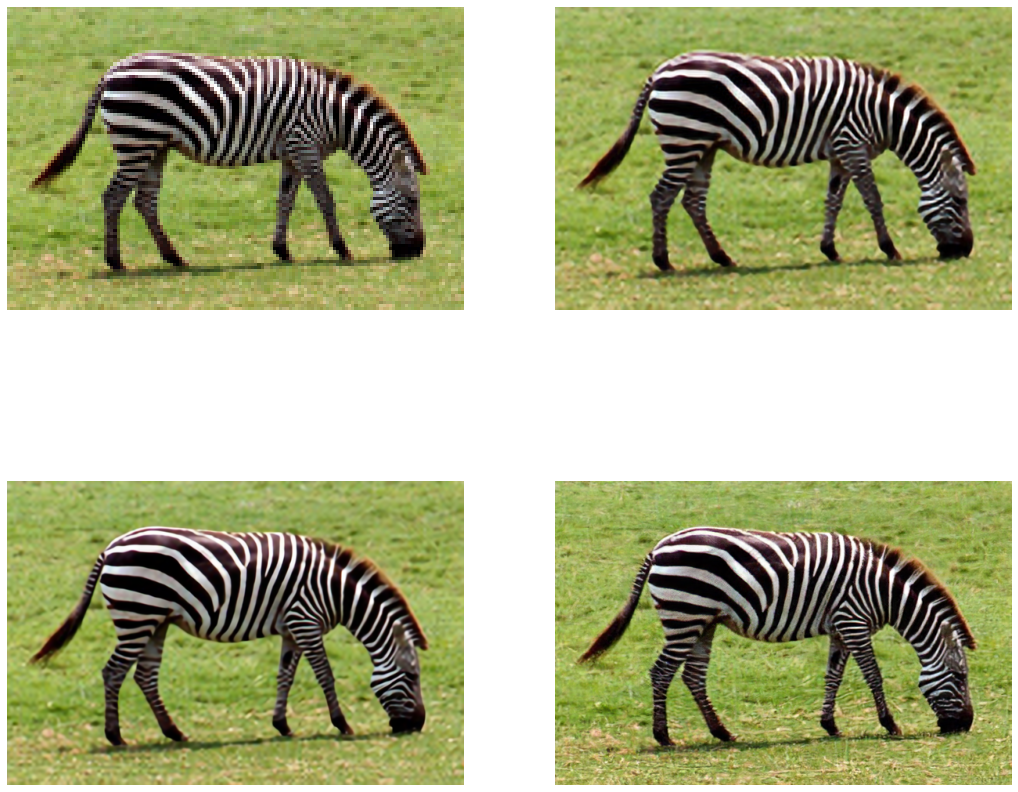

In [ ]:
# Load LR and GT images
zebra_lr = mmcv.imread('./data/zebra_x4.png', channel_order='rgb')  # read GT (Ground-Truth) image
# Load SRCNN and RRDB-Net results
zebra_srcnn = mmcv.imread('./results/zebra_SRCNN.png', channel_order='rgb')
zebra_rrdb_net = mmcv.imread('./results/zebra_RRDB-Net.png', channel_order='rgb')
# Load ESRGAN result
zebra_esrgan = mmcv.imread('./results/zebra_ESRGAN.png', channel_order='rgb')

# Plot figures
fig = plt.figure(figsize=(18, 16))
ax1 = fig.add_subplot(2, 2, 1)  # 2 rows, 2 columns, the top left image  
ax1.axis('off')
ax2 = fig.add_subplot(2, 2, 2)  # 2 rows, 2 columns, the top right image  
ax2.axis('off')
ax3 = fig.add_subplot(2, 2, 3)  # 2 rows, 2 columns, the top right image  
ax3.axis('off')
ax4 = fig.add_subplot(2, 2, 4)  # 2 rows, 2 columns, the bottom right image  
ax4.axis('off')
ax1.imshow(zebra_lr)
ax2.imshow(zebra_srcnn)
ax3.imshow(zebra_rrdb_net)
ax4.imshow(zebra_esrgan)

# Balance PSNR-oriented Results and Perceptual Quality

How to balance the PSNR-oriented results and GAN effects to meet various user flavors and application scenarios?

We introduce a simple yet effective technique to achieve this goal - Deep Network Interpolation.

It actually interplotes two networks in their parameter space! 

Sounds crazy? Let's look at what it does!



This is the illustration of Deep Network Interpolation (DNI).

Provided with a model for a particular effect A, we fine-tune it to realize another relevant effect B. 

DNI applies linear interpolation for all the corresponding parameters of these two deep networks. 

Various interpolated models can then be derived by a controllable interpolation coefficient. 

Performing feed-forward operations on these interpolated models using the same input allows us to produce output with a continuous transition between the different effects A and B.

![](https://raw.githubusercontent.com/xinntao/public-figures/master/MMEditing-Tutorial/DNI_1.jpg)

![](https://raw.githubusercontent.com/xinntao/public-figures/master/MMEditing-Tutorial/DNI_2.jpg)

Let's first look at the parameters of the network.

In [ ]:
import torch
net_rrdb_net = torch.load('checkpoints/esrgan_psnr_x4c64b23g32_1x16_1000k_div2k_20200420-bf5c993c.pth')

for key, value in net_rrdb_net['state_dict'].items():
  print(key)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

generator.conv_first.weight
generator.conv_first.bias
generator.body.0.rdb1.conv1.weight
generator.body.0.rdb1.conv1.bias
generator.body.0.rdb1.conv2.weight
generator.body.0.rdb1.conv2.bias
generator.body.0.rdb1.conv3.weight
generator.body.0.rdb1.conv3.bias
generator.body.0.rdb1.conv4.weight
generator.body.0.rdb1.conv4.bias
generator.body.0.rdb1.conv5.weight
generator.body.0.rdb1.conv5.bias
generator.body.0.rdb2.conv1.weight
generator.body.0.rdb2.conv1.bias
generator.body.0.rdb2.conv2.weight
generator.body.0.rdb2.conv2.bias
generator.body.0.rdb2.conv3.weight
generator.body.0.rdb2.conv3.bias
generator.body.0.rdb2.conv4.weight
generator.body.0.rdb2.conv4.bias
generator.body.0.rdb2.conv5.weight
generator.body.0.rdb2.conv5.bias
generator.body.0.rdb3.conv1.weight
generator.body.0.rdb3.conv1.bias
generator.body.0.rdb3.conv2.weight
generator.body.0.rdb3.conv2.bias
generator.body.0.rdb3.conv3.weight
generator.body.0.rdb3.conv3.bias
generator.body.0.rdb3.conv4.weight
generator.body.0.rdb3.conv4

Interpolate with coefficient 0.8.

It merely performs a linear combination on the two network parameters.

In [ ]:
net_esrgan = torch.load('checkpoints/esrgan_x4c64b23g32_1x16_400k_div2k_20200508-f8ccaf3b.pth')
alpha = 0.8
interpolated_net = {'meta': f'interpolated network with alpha {alpha}', 'state_dict': dict()}
for key, value in net_rrdb_net['state_dict'].items():
  interpolated_net['state_dict'][key] = alpha * net_rrdb_net['state_dict'][key] + (1-alpha) * net_esrgan['state_dict'][key]

torch.save(interpolated_net, './interpolated_net.pth')

## Inference with the interpolated network

The model and loaded state dict do not match exactly

missing keys in source state_dict: discriminator.conv0_0.weight, discriminator.conv0_0.bias, discriminator.conv0_1.weight, discriminator.bn0_1.weight, discriminator.bn0_1.bias, discriminator.bn0_1.running_mean, discriminator.bn0_1.running_var, discriminator.conv1_0.weight, discriminator.bn1_0.weight, discriminator.bn1_0.bias, discriminator.bn1_0.running_mean, discriminator.bn1_0.running_var, discriminator.conv1_1.weight, discriminator.bn1_1.weight, discriminator.bn1_1.bias, discriminator.bn1_1.running_mean, discriminator.bn1_1.running_var, discriminator.conv2_0.weight, discriminator.bn2_0.weight, discriminator.bn2_0.bias, discriminator.bn2_0.running_mean, discriminator.bn2_0.running_var, discriminator.conv2_1.weight, discriminator.bn2_1.weight, discriminator.bn2_1.bias, discriminator.bn2_1.running_mean, discriminator.bn2_1.running_var, discriminator.conv3_0.weight, discriminator.bn3_0.weight, discriminator.bn3_0.bias, discriminator.

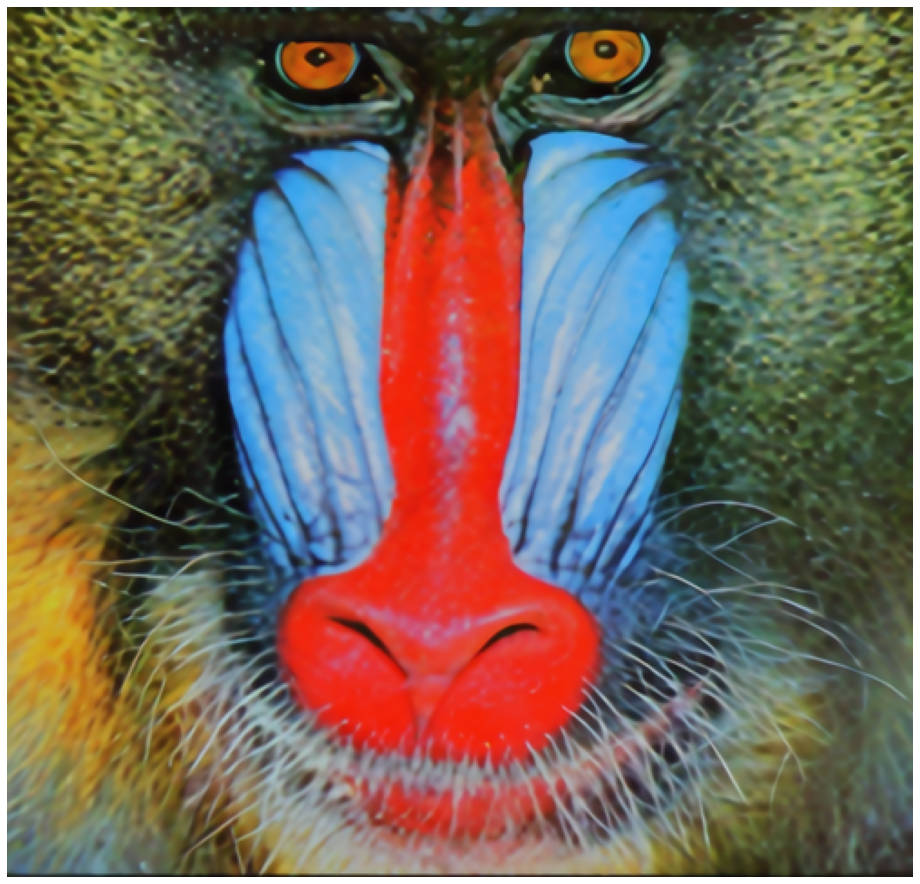

In [ ]:
config = 'configs/restorers/esrgan/esrgan_x4c64b23g32_g1_400k_div2k.py'
checkpoint = 'interpolated_net.pth'
img_path = 'data/baboon_x4.png'
save_path = 'results/baboon_ESRGAN_interpolated.png'

model = init_model(
        config, checkpoint, device=torch.device('cuda'))

output = restoration_inference(model, img_path)
output = tensor2img(output)

mmcv.imwrite(output, save_path)

# visualize 
img_interp = mmcv.imread('results/baboon_ESRGAN_interpolated.png', channel_order='rgb')

fig = plt.figure(figsize=(18, 16))
ax1 = fig.add_subplot(1, 1, 1)
ax1.axis('off')
ax1.imshow(img_interp)

Cannot see the difference? Now let's do some fancy work!

Let's interpolate between two networks with an interval of 0.05.

In [ ]:

import numpy as np
for alpha in list(np.arange(0, 1.05, 0.05)):
    print(f'Interpolating with alpha = {alpha:.2f}...')
    interpolated_net = {'meta': f'interpolated network with alpha {alpha}', 'state_dict': dict()}
    for key, value in net_rrdb_net['state_dict'].items():
        interpolated_net['state_dict'][key] = alpha * net_rrdb_net['state_dict'][key] + (1-alpha) * net_esrgan['state_dict'][key]

    torch.save(interpolated_net, f'./interpolated_net_{int(alpha*100):03d}.pth')

Interpolating with alpha = 0.00...
Interpolating with alpha = 0.05...
Interpolating with alpha = 0.10...
Interpolating with alpha = 0.15...
Interpolating with alpha = 0.20...
Interpolating with alpha = 0.25...
Interpolating with alpha = 0.30...
Interpolating with alpha = 0.35...
Interpolating with alpha = 0.40...
Interpolating with alpha = 0.45...
Interpolating with alpha = 0.50...
Interpolating with alpha = 0.55...
Interpolating with alpha = 0.60...
Interpolating with alpha = 0.65...
Interpolating with alpha = 0.70...
Interpolating with alpha = 0.75...
Interpolating with alpha = 0.80...
Interpolating with alpha = 0.85...
Interpolating with alpha = 0.90...
Interpolating with alpha = 0.95...
Interpolating with alpha = 1.00...


In [ ]:
import mmcv
import torch
from mmedit.apis import init_model, restoration_inference
from mmedit.core import tensor2img

config = 'configs/restorers/esrgan/esrgan_x4c64b23g32_g1_400k_div2k.py'
img_path = 'data/baboon_x4.png'
for alpha in list(np.arange(0, 1.05, 0.05)):
    checkpoint = f'./interpolated_net_{int(alpha*100):03d}.pth'
    print(f'Inference with {checkpoint}...')
    save_path = f'results/baboon_interpolated_{int(alpha*100):03d}.png'

    model = init_model(
            config, checkpoint, device=torch.device('cuda'))

    output = restoration_inference(model, img_path)
    output = tensor2img(output)

    mmcv.imwrite(output, save_path)

Inference with ./interpolated_net_000.pth...
The model and loaded state dict do not match exactly

missing keys in source state_dict: discriminator.conv0_0.weight, discriminator.conv0_0.bias, discriminator.conv0_1.weight, discriminator.bn0_1.weight, discriminator.bn0_1.bias, discriminator.bn0_1.running_mean, discriminator.bn0_1.running_var, discriminator.conv1_0.weight, discriminator.bn1_0.weight, discriminator.bn1_0.bias, discriminator.bn1_0.running_mean, discriminator.bn1_0.running_var, discriminator.conv1_1.weight, discriminator.bn1_1.weight, discriminator.bn1_1.bias, discriminator.bn1_1.running_mean, discriminator.bn1_1.running_var, discriminator.conv2_0.weight, discriminator.bn2_0.weight, discriminator.bn2_0.bias, discriminator.bn2_0.running_mean, discriminator.bn2_0.running_var, discriminator.conv2_1.weight, discriminator.bn2_1.weight, discriminator.bn2_1.bias, discriminator.bn2_1.running_mean, discriminator.bn2_1.running_var, discriminator.conv3_0.weight, discriminator.bn3_0.wei

In [ ]:
# Create a gif image
import imageio
images = []
for alpha in list(np.arange(0, 1.05, 0.05)):
    img_path = f'results/baboon_interpolated_{int(alpha*100):03d}.png'
    images.append(imageio.imread(img_path))
images.reverse()
imageio.mimsave('results/baboon.gif', images)

In [ ]:
from IPython.display import Image
Image(open('results/baboon.gif','rb').read())

Output hidden; open in https://colab.research.google.com to view.

We can now achieve a continuous and smooth transition from PSNR-oriented outputs to GAN effects.

# What to Do Next?




- Blind super-resolution: The images captured form the real world have various down-sampling kernels. Blind super-resolution is indeed essential towards real-world applications. [IKC](https://arxiv.org/abs/1904.03377)
- Video super-resolution: Apply image super-resolution to videos. [EDVR](https://arxiv.org/abs/1905.02716)
- Metrics: Metrics are important for perceptual SR. [lpips](https://arxiv.org/pdf/1801.03924.pdf)


